# End-To-End Training Example of RNN for rain estimation and detection using PyNNCML
This notebook presents an end-to-end example of training a Recurrent Neural Network (RNN) based rain estimation neural network [1] on the openMRG dataset.
This tutorial is built using the PyNNCML software package, which provides both tools to simplify the training process of deep learning models for CMLs.
We start with obtaining a subset of the OpenMRG dataset and splitting it into training and validation datasets.
Afterward, we construct the One Step Network from [1], followed by the training loop.
Finally, we analyze the model performance in terms of RMSE and Bias.


Notebook structure
1. Imports and Installation of PyNNCML
2. Hyperparameter settings
3. Build Dataset
4. Build Neural Network
5. Training Loop
6. Neural Network Analysis


[Run this notebook in colab](https://colab.research.google.com/github/haihabi/PyNNcml/blob/master/examples/training_rnn.ipynb)

To run this notebook on Colab using GPU, please do the following:
Runtime -> Change runtime type -> Select GPU -> Save


In [1]:
import sys
import os
%load_ext gradio
if os.path.exists('../pynncml'):
    print("Import PyNNCML From Code")
    sys.path.append('../')  # This line is need to import pynncml
else:
    print("Install PyNNCML From pip")
    !pip install pynncml

import numpy as np
import pynncml as pnc
import torch
import math
from matplotlib import pyplot as plt
from tqdm import tqdm

Import PyNNCML From Code


In [2]:
window_size = 32
lr = 1e-4
n_epochs = 200
xy_min = [1.29e6, 0.565e6]  # Link Region
xy_max = [1.34e6, 0.5875e6]
time_slice = slice("2015-06-01", "2015-06-10")  # Time Interval
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Building Training and Validation datasets

File already exists at desired location ./data/OpenMRG.zip
Not downloading!


100%|██████████| 728/728 [00:28<00:00, 25.70it/s]


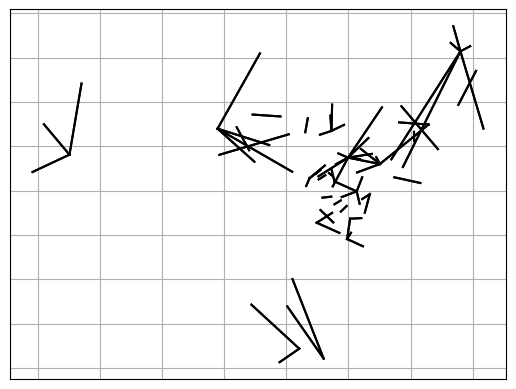

In [3]:
link_set, ps = pnc.datasets.load_open_mrg(xy_min=xy_min, xy_max=xy_max, time_slice=time_slice, change2min_max=True)
link_set.plot_links()
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()



# Neural Network

In [4]:
model = pnc.scm.rain_estimation.one_step_dynamic_baseline(pnc.scm.power_law.PowerLawType.MAX, 0.3, 8,
                                                          quantization_delta=0.3)
imc = pnc.mcm.InferMultipleCMLs(model)

res = imc(link_set)


tensor(34139.2695) tensor(47.6270)


In [31]:
idw = pnc.mcm.InverseDistanceWeighting(64, 64,roi=0.1,r=4)
rain_map = idw(res, link_set).numpy()
print(torch.sum(res),torch.max(res))

tensor(34139.2695) tensor(47.6270)


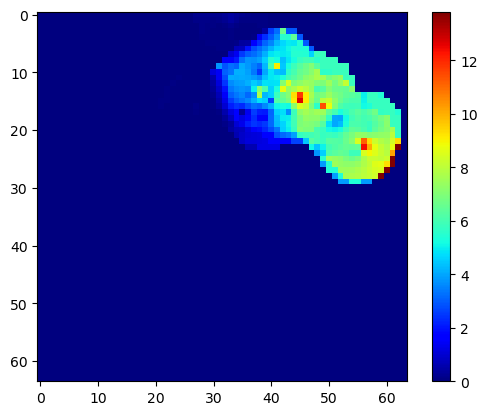

In [35]:
index=np.argmax(np.std(rain_map, axis=(1, 2)))

plt.imshow(rain_map[index, :, :].T, cmap='jet')
plt.colorbar()
plt.show()

In [21]:
%%blocks

import gradio as gr
print(np.sum(rain_map))
_rain_map=rain_map/np.max(rain_map)
class RainMapPlayer:
    def __init__(self, rain_map):
        self.rain_map = rain_map

    def __call__(self, steps):
        return self.rain_map[steps, :, :]




# with gr.Blocks() as demo:
demo = gr.Interface(RainMapPlayer(_rain_map),
                    inputs=gr.Slider(1, _rain_map.shape[0], 3, step=1),
                    outputs="image")


997289.3
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


# Training Loop

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.ioff()
fig, ax = plt.subplots()
# np array with shape (frames, height, width, channels)
video = np.array([...])

fig = plt.figure()
im = plt.imshow(rain_map[0, :, :])

plt.close()  # this is required to not display the generated image


def init():
    im.set_data(video[0, :, :])


def animate(i):
    im.set_data(video[i, :, :])
    return im


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_jshtml())
